In [1]:

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
import numpy as np
import torch
from torch import nn
import os
from torch.utils.data import DataLoader, random_split
from torch.nn import DataParallel
from torch.utils.data import Subset
import shutil
from codes.helpers import FocalLoss

In [2]:
# Hyperparameters
# We can adjust the learning_rate here to improve the model performance, scheduler is used to reduce the learning rate at specific epochs
# The batch size can be adjusted based on the available memory
# If apply_augmentations is set to True, the model will apply augmentations to the images to improve the model performance
load_saved_model = False
apply_augmentations = True
training_epoch = 400
batch_size = 16
learning_rate = 0.00001
momentum = 0.9
weight_decay = 0.00005
scheduler = 1

device = "cuda:1"
logdir = "logs/"
resultdir = "logs/results/"

if os.path.exists(resultdir):
    shutil.rmtree(resultdir)
os.makedirs(resultdir)

In [3]:
class Fashion_Data(Dataset):
    def __init__(self, folder_train, folder_ground_truth, augmentation=None):
        self.folder_train = folder_train
        self.folder_ground_truth = folder_ground_truth
        self.transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]) if augmentation is None \
                            else transforms.Compose([augmentation, transforms.Resize((256, 256)), transforms.ToTensor()]) 
        
        self.filenames = [f for f in os.listdir(folder_train) if os.path.isfile(os.path.join(folder_train, f))]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name_train = os.path.join(self.folder_train, self.filenames[idx])
        img_name_gt = os.path.join(self.folder_ground_truth, self.filenames[idx])

        img_train = Image.open(img_name_train).convert('RGB')
        img_gt = Image.open(img_name_gt).convert('RGB')

        if self.transform:
            img_train = self.transform(img_train)
            img_gt = self.transform(img_gt)

        return img_train, img_gt

Train size: 2764, Test size: 308
Shape of the images: torch.Size([3, 256, 256])


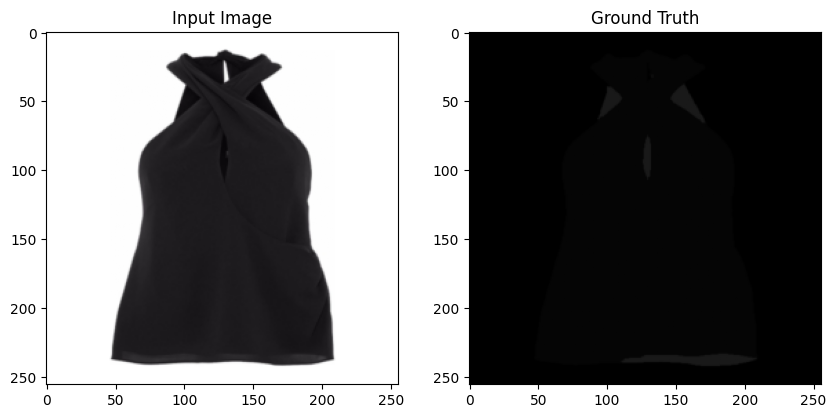

In [4]:
train_folder = "dataset/upper/cloth_align"
gt_folder = "dataset/upper/cloth_align_parse-bytedance"

full_set = Fashion_Data(train_folder, gt_folder)

# We want to validate model using fraction dataset (how many percent parts of the dataset will be used)
fraction_size = 0.2
# Calculate sizes
full_dataset_size = len(full_set)
subset_size = int(fraction_size * full_dataset_size)  # Total size of the subset to use

# Create indices for the subset
subset_indices = torch.randperm(full_dataset_size)[:subset_size].tolist()

# Create a subset based on the indices
subset = Subset(full_set, subset_indices)

# Now, calculate train and test sizes for the subset
train_size = int(0.9 * len(subset))  # 90% of the subset size
test_size = len(subset) - train_size  # The rest for testing

# Split the subset into train and test
train_dataset, test_dataset = random_split(subset, [train_size, test_size], generator=torch.Generator().manual_seed(42))


dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

# Get the example image from the train dataset
first_image_train, first_image_gt = train_dataset[10]
print(f'Shape of the images: {first_image_train.shape}')

# Plot the first image side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(first_image_train.permute(1, 2, 0))
axes[0].set_title('Input Image')
axes[1].imshow(first_image_gt.permute(1, 2, 0))
axes[1].set_title('Ground Truth')


plt.show()

In [5]:
# The diagram is provided to understand the architecture
from architecture.unet_blocks import DoubleConv, Down, Up, OutConv
from architecture.segnet import SegNet
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


model = SegNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [6]:
# The code to make sure the model input and output are correct, we can test the first batch to fed into the network
data = next(iter(dataloader_train))

test_data = data[0]
output_test = model(test_data.to(device))
print(output_test.shape)

torch.Size([16, 1, 256, 256])


In [7]:
from tqdm import tqdm
from torchvision.utils import save_image

class Engine(object):
    def __init__(self, model, optimizer, device, ema=None):
        # Initialize the Engine with the model, optimizer, and the device it's running on.
        self.model = model
        self.optimizer = optimizer
        self.device = device
        # Current epoch of training.
        self.cur_epoch = 0
        # Number of iterations the training has run.
        self.cur_iter = 0
        # The best validation epoch, used to track the epoch with the best validation performance.
        self.bestval_epoch = 0
        # Lists to track the training and validation losses.
        self.train_loss = []
        self.val_loss = []
        # Criterion for calculating loss. Here, it's Mean Squared Error Loss for regression tasks.
        self.criterion = torch.nn.MSELoss()

    """ Block to begin training """
    def train(self, dataloader_train):
        loss_epoch = 0.
        num_batches = 0
        # Set the model to training mode.
        self.model.train()
        
        # Train loop
        # tqdm is used to display the training progress for each epoch.
        pbar = tqdm(dataloader_train, desc='Train Epoch {}'.format(self.cur_epoch))
        for data in pbar:
            # efficiently zero gradients
            # Zero the gradients before running the backward pass.
            self.optimizer.zero_grad(set_to_none=True)
            images = data[0].to(self.device, dtype=torch.float32)   # Image that will be fed into network
            gt_mass = data[1].to(self.device, dtype=torch.float32)  # Ensure gt_mass is a float tensor, The ground truth of mass

            # Pass the images through the model to get predictions.
            pred_mass = self.model(images)

            # Calculate the loss, backpropagation, and optimization
            loss = self.criterion(pred_mass, gt_mass)
            loss.backward()
            # Perform a single optimization step (parameter update).
            self.optimizer.step()

            # Aggregate the loss for the epoch
            loss_epoch += float(loss.item())
            num_batches += 1

            pbar.set_description("Loss: {:.4f}".format(loss.item()))
            
        pbar.close()
        avg_loss = loss_epoch / num_batches
        self.train_loss.append(avg_loss)

        self.cur_epoch += 1
        pbar.set_description("Epoch: {}, Average Loss: {:.4f}".format(self.cur_epoch, avg_loss))

    def test(self, dataloader_test):
        self.model.eval()
        loss_epoch = 0.
        num_batches = 0
        
        # Create a directory for the current epoch's results
        epoch_result_dir = os.path.join(resultdir, str(self.cur_epoch))
        os.makedirs(epoch_result_dir, exist_ok=True)

        # Prepare to collect predictions and ground truth
        with torch.no_grad():  # No need to calculate gradients
            pbar = tqdm(dataloader_test, desc='Test Epoch {}'.format(self.cur_epoch))
            for batch_idx, data in enumerate(pbar):
                images = data[0].to(self.device, dtype=torch.float32)
                gt_mask = data[1].to(self.device, dtype=torch.float32)

                pred_mask = self.model(images)

                loss = self.criterion(pred_mask, gt_mask)
                loss_epoch += float(loss.item())
                num_batches += 1
                pbar.set_description("Test Loss: {:.4f}".format(loss.item()))
                
                for idx, pred in enumerate(pred_mask):
                    save_image(pred, os.path.join(epoch_result_dir, f'prediction_{batch_idx}_{idx}.png'))

        avg_loss = loss_epoch / num_batches
        self.val_loss.append(avg_loss)
        
        print(f"Test Epoch: {self.cur_epoch}, Average Loss: {avg_loss:.4f}")
        return avg_loss


In [8]:
from codes.scheduler import CyclicCosineDecayLR

# The scheduler is used to reduce the learning rate at specific epochs
if scheduler:
	scheduler = CyclicCosineDecayLR(optimizer,
	                                init_decay_epochs=80,
	                                min_decay_lr=2.5e-6,
	                                restart_interval = 10,
	                                restart_lr=12.5e-5,
	                                warmup_epochs=20,
	                                warmup_start_lr=2.5e-6)


trainer = Engine(model, optimizer, device, ema=None)

# Load the saved model if load_saved_model is set to True
if load_saved_model:
	model.load_state_dict(torch.load('logs/final_model.pth'))
 
# Count the total number of trainable parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print ('======Total trainable parameters: ', params)

for epoch in range(trainer.cur_epoch, training_epoch):
	trainer.train(dataloader_train)

	# Test the model every 20 epochs and save it to logs folder
	if (epoch) % 20 == 0:
		trainer.test(dataloader_test)
		torch.save(model.state_dict(), os.path.join('logs', 'final_model.pth'))
	if scheduler:
		scheduler.step()


/home/cqilab/anaconda3/envs/sam/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


======Total trainable parameters:  29443585


Train Epoch 0:   0%|          | 0/173 [00:00<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [16, 3, 256, 256]

In [ ]:
torch.save(model.state_dict(), os.path.join('logs', 'final_model.pth'))